Available on [GitHub](https://github.com/federicosilvestri/data-mining).

# DM - Time series analysis [TASK 4.1]

Extrapolation of success score timeseries and analysis about them.

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
import pandas as pd
from tqdm import tqdm_notebook
import zlib

from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform
import scipy.stats as stats

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import os
import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

nb_workers = int(os.cpu_count() / 2 + 1)

pandarallel.initialize(
    progress_bar=True,
    nb_workers=nb_workers,
)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Fetching users and tweets dataset saved.

In [2]:
# Load the users and tweets dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="outlier_detection")
users = dataset['users.pickle']
tweets = dataset['tweets.pickle']

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              11508 non-null  int64         
 1   name            11508 non-null  string        
 2   lang            11508 non-null  string        
 3   bot             11508 non-null  bool          
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11508 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), string(2)
memory usage: 550.7 KB


In [4]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10266779 entries, 0 to 13664695
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   retweet_count   float64       
 2   reply_count     float64       
 3   favorite_count  float64       
 4   num_hashtags    float64       
 5   num_urls        float64       
 6   num_mentions    float64       
 7   created_at      datetime64[ns]
 8   text            string        
dtypes: datetime64[ns](1), float64(6), object(1), string(1)
memory usage: 783.3+ MB


## Data preparing

Remove tweets with invalid `user_id`.

In [5]:
user_ids = set([str(i) for i in users['id'].values.tolist()])

tweets = tweets[tweets['user_id'].map(lambda i: i in user_ids)].astype({'user_id': 'int64'})

Tweets filtering by date and sorting by it. Here are used tweets of year 2019.

In [6]:
INIT_2019_TIMESTAMP = pd.Timestamp('2019-01-01')
INIT_2020_TIMESTAMP = pd.Timestamp('2020-01-01')

mask_tweets_2019 = tweets['created_at'].parallel_map(lambda t: INIT_2019_TIMESTAMP <= t < INIT_2020_TIMESTAMP)
tweets = tweets[mask_tweets_2019]
tweets = tweets.sort_values(by=['created_at'])

tweets

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
8384098,2240858066,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:21:18,tava me sentindo super mal esses dias
6210422,2240858066,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:23:50,Ãs vezes tudo o que a gente precisa pra se se...
6852918,2240858066,4.0,0.0,0.0,0.0,0.0,1.0,2019-01-01 00:24:30,RT @myh3ro: TO FAZENDO TODO MUNDO ASSISTIR SHE...
192212,494302461,1.0,0.0,0.0,0.0,0.0,0.0,2019-01-01 00:47:32,"Ã cosÃ¬, mente e cuore sono anarchici nella l..."
7159403,494302461,8.0,0.0,7.0,0.0,0.0,0.0,2019-01-01 00:48:03,"Le cose piÃ¹ belle non sono perfette, sono spe..."
...,...,...,...,...,...,...,...,...,...
7460655,2275740517,1.0,0.0,1.0,0.0,0.0,0.0,2019-11-15 22:02:30,Anche la mia mamma quando ero piccolo mi sgrid...
12234385,2273349732,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:03:55,LE DIFFICOLTA' SONO COME LA CARTAIGIENICA... N...
9099401,2275248397,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:05:08,Tra 20 anni sarai deluso per ciÃ² che non hai ...
9440580,2274254095,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-15 22:10:43,"Vuoi sapere chi sei? Non chiedertelo, agisci: ..."


Computation of indexes `acceptance_score` and `diffusion_score` to combine them in the `success_score`.

In [7]:
acceptance_score = tweets['retweet_count'] + tweets['reply_count'] + tweets['favorite_count']
diffusion_score = tweets['num_hashtags'] + tweets['num_mentions'] + tweets['num_urls']

tweets["success_score"] = acceptance_score / (diffusion_score + 0.1)

tweets["success_score"].describe()

count    4.474637e+06
mean     1.337116e+02
std      4.083013e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.090909e-01
max      1.823150e+06
Name: success_score, dtype: float64

Useless columns removal.

In [8]:
users = users[["id", "bot"]]
tweets = tweets[["user_id", "success_score", "created_at"]]

Success score timeseries column addition. Here it's created a new column for each users with the list of `success_score` ordered by `created_at` date. Each of these list has length of days in a year (365).

In [9]:
def time_series_by_days(group):
    result = [-1 for _ in range(365)]
    success_score_serie = group.groupby(tweets["created_at"].dt.date)["success_score"].sum()
    for index, success_score in success_score_serie.items():
        result[pd.Period(index, freq='D').day_of_year - 1] = success_score
    return result

tweets_grouped_by_users = tweets.groupby(["user_id"]).parallel_apply(time_series_by_days)

users = users.merge(tweets_grouped_by_users.to_frame("success_score"), left_on='id', right_index=True)

`users` preprocessed dataframe.

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6787 entries, 0 to 11506
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             6787 non-null   int64 
 1   bot            6787 non-null   bool  
 2   success_score  6787 non-null   object
dtypes: bool(1), int64(1), object(1)
memory usage: 165.7+ KB


In [11]:
users

,id,bot,success_score
0,2353593986,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,2358850842,False,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,466124818,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
5,2199062688,False,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9,2357425536,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...
11496,39220893,False,"[-1, -1, 1.8181818181818181, 18.00586510263929..."
11497,2364069194,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11501,2364683192,True,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
11504,1378532629,False,"[-1, -1, 20.0, 0.0, 0.0, 0.0, 161.818181818181..."


Users dataset base statistics.

In [12]:
lg.info(f'number of time series: {users.shape[0]}')
lg.info(f'size of each time serie: {len(users["success_score"][0])}')

2023-01-07 04:44:13,200 - root - INFO - number of time series: 6787
2023-01-07 04:44:13,200 - root - INFO - size of each time serie: 365


Plot of some time series colored according related class.

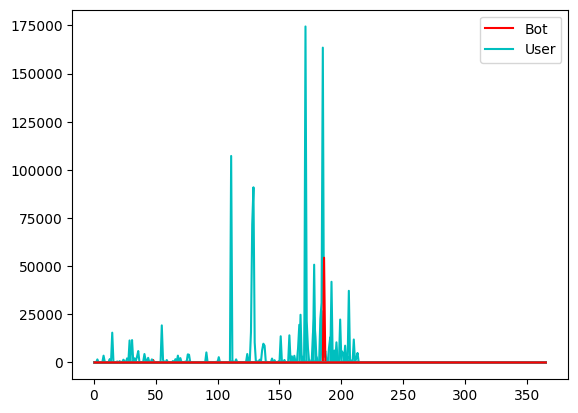

In [13]:
for i, user in list(users.iterrows())[:30]:
    success_score = user["success_score"]
    color = "r" if user["bot"] else "c"
    plt.plot(range(1, len(success_score) + 1), success_score, c=color)

plt.legend(['Bot', 'User'])
plt.show()

In [14]:
# save time series users pickle
store_preprocessed_dataset(step_name="timeseries", file_name="users.pickle", df=users)

In [2]:
# Load the users dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="timeseries")
users = dataset['users.pickle']

Function able to extract numpy matrix from `success_score` column of `users` dataframe.

In [3]:
def extract_success_score(dt):
    return np.array([t for t in dt["success_score"].values])

## Time series clustering

`X` is the matrix representing the clustering dataset.

In [4]:
X = extract_success_score(users)

X.shape

(6787, 365)

Here is defined the Compression-based Dissimilarity Measure (CDM) metric to evaluate models.

In [5]:
def cdm_metric(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

Abstraction of grid search to run it with different clustering models and plot results. This algorithm try to run models with different params and plots results to provide the programmer a way to decide the best parameters.

In [6]:
def gridsearch_plot(create_model, params, x, labels=None, metric_callback=None):
    xvalues = []
    inertias = []
    metric_callback = metric_callback if metric_callback is not None else (lambda m: m.inertia_)
    for i, param in enumerate(tqdm_notebook(params)):
        model = create_model(param)
        model.fit(x)
        metric = metric_callback(model)
        if metric is not None:
            xvalues.append(param["xvalue"] if "xvalue" in param else i)
            inertias.append(metric)
    plt.plot(xvalues, inertias)
    if labels is not None:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    plt.grid(True)
    plt.show()

Clustering dataset scaling.

In [7]:
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)

### KMeans for time series

Time series kmeans grid search to find the best k.

  0%|          | 0/29 [00:00<?, ?it/s]

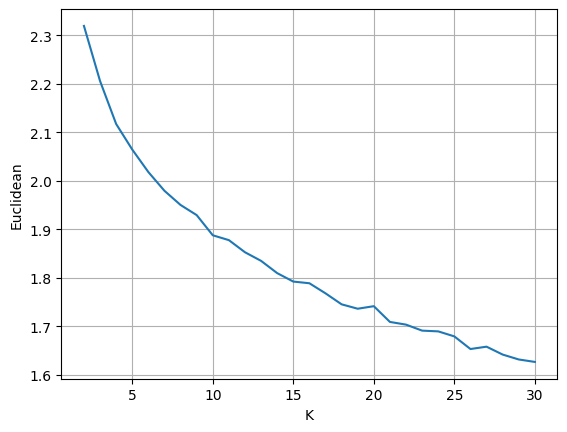

In [8]:
params_kmeans_ts = [{'k': i, 'xvalue': i} for i in list(range(2, 31))]
def create_kmeans_ts(param):
    return TimeSeriesKMeans(n_clusters=param["k"], metric="euclidean", max_iter=100, n_init=10, n_jobs=-1)

gridsearch_plot(create_kmeans_ts, params_kmeans_ts, X_scaled, ("K", "Euclidean"))

Model construction and fitting with best k found.

In [9]:
kmeans_ts = create_kmeans_ts({"k": 13})
kmeans_ts.fit(X_scaled)

lg.info(f'Euclidean: {kmeans_ts.inertia_}')
lg.info(f'CDM: {cdm_metric(X_scaled, kmeans_ts.labels_)}')

2023-01-07 11:48:18,247 - root - INFO - Euclidean: 1.8365348193540505
2023-01-07 11:48:19,200 - root - INFO - CDM: 1.0001900290720824


Cluster centers discovered plot.

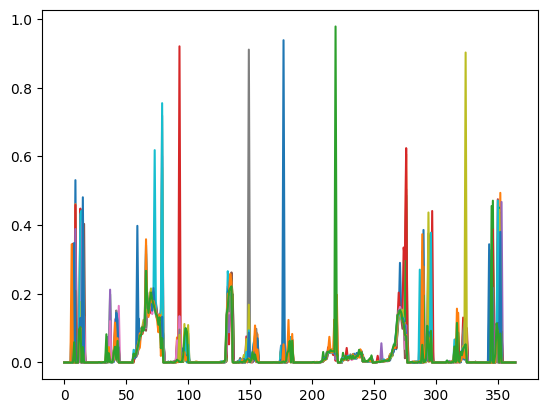

In [10]:
cluster_centers = kmeans_ts.cluster_centers_
plt.plot(cluster_centers.reshape(cluster_centers.shape[1], -1))

plt.show()

Definition of function to plot distribution among clusters and usage of it for time series kmeans model.

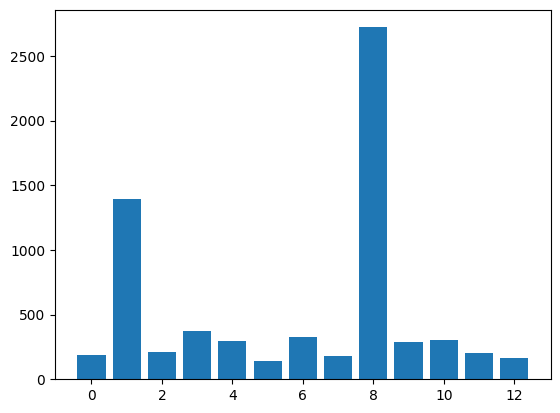

In [11]:
def plot_clusters_distribution(model):
    labels_distribution = np.unique(model.labels_, return_counts=True)
    plt.bar(labels_distribution[0], labels_distribution[1])
    plt.show()

plot_clusters_distribution(kmeans_ts)

Definition of function to plot distribution among clusters and bot label and usage of it for time series kmeans model.

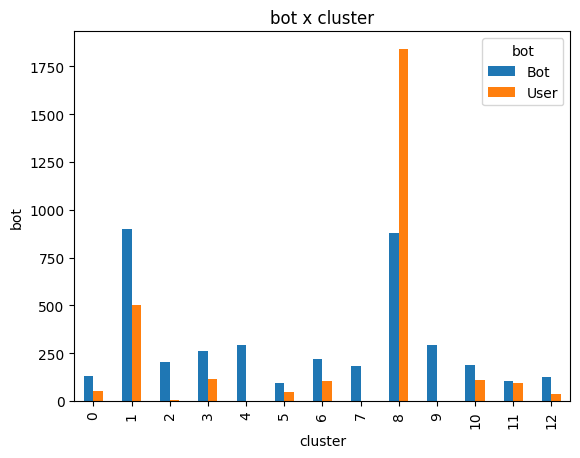

bot    Bot  User
row_0           
0      130    54
1      897   500
2      203     5
3      261   114
4      294     0
5       93    49
6      222   105
7      182     0
8      880  1841
9      292     0
10     189   112
11     107    94
12     125    38


In [12]:
def plot_bot_distribution(model):
    users_pct = pd.crosstab(model.labels_, users['bot'].map(lambda x: 'Bot' if x else 'User'))

    users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
    plt.xlabel('cluster')
    plt.ylabel('bot')
    plt.show()
    print(users_pct)

plot_bot_distribution(kmeans_ts)

### Symbolic Aggregate Approximation (SAX)

Sax compressed time series creation from clustering dataset.

In [13]:
n_segments = 20
sax = SymbolicAggregateApproximation(n_segments=n_segments, alphabet_size_avg=8)
X_sax = sax.fit_transform(X)

X_sax.shape

(6787, 20, 1)

Plot of some comparisons of timeseries and their sax compression.

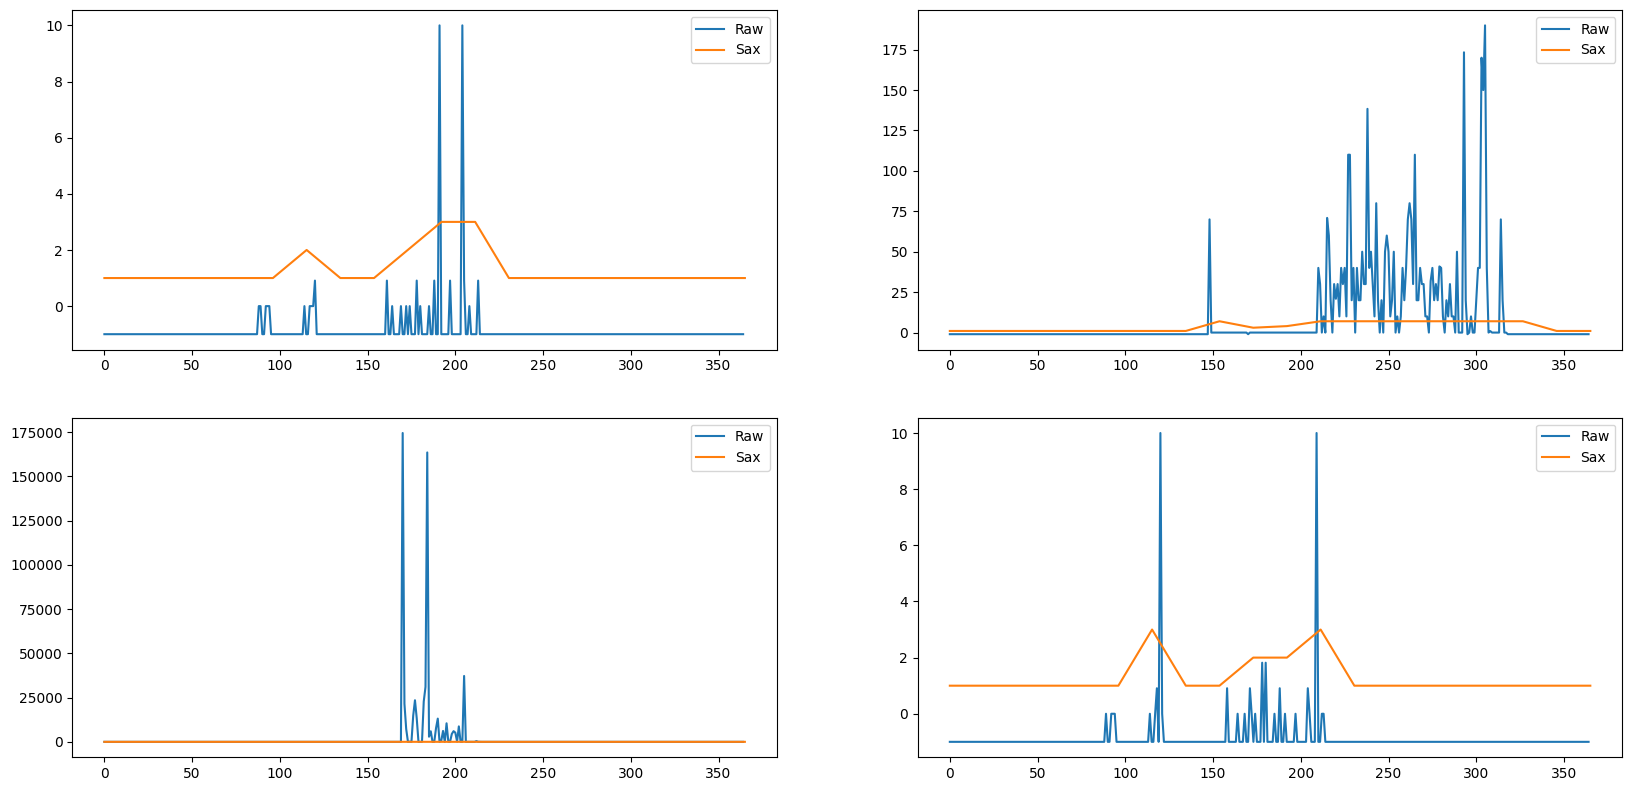

In [14]:
max_num_plots = 4

rows = max_num_plots // 2 + 1
plt.figure(figsize=(20, rows * 5))
offset = X.shape[1] / (n_segments - 1)
for i in range(1, max_num_plots + 1):
    plt.subplot(rows, 2, i)
    plt.plot(X[i], label="Raw")
    plt.plot([i * offset for i in range(X_sax[i].shape[0])], X_sax[i].squeeze(), label="Sax")
    plt.legend()

plt.show()

Sax dataset scaling.

In [15]:
scaler = TimeSeriesScalerMinMax()
X_sax_scaled = scaler.fit_transform(X_sax)

Sax time series grid search.

  0%|          | 0/29 [00:00<?, ?it/s]

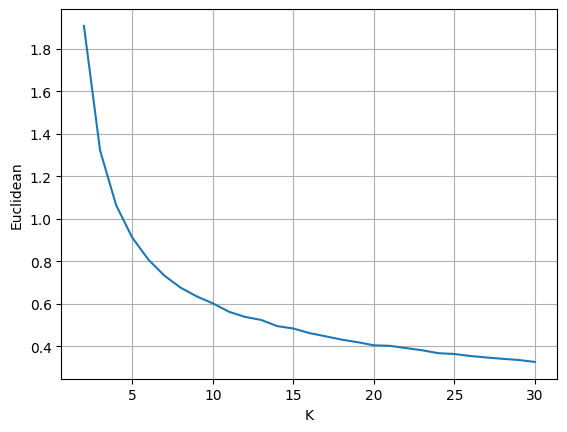

In [16]:
gridsearch_plot(create_kmeans_ts, params_kmeans_ts, X_sax_scaled, ("K", "Euclidean"))

Creation of kmeans model with the best k and fitting of it.

In [17]:
kmeans_sax_ts = create_kmeans_ts({"k": 8})
kmeans_sax_ts.fit(X_sax_scaled)

lg.info(f'Euclidean: {kmeans_sax_ts.inertia_}')
lg.info(f'CDM: {cdm_metric(X_sax_scaled, kmeans_sax_ts.labels_)}')

2023-01-07 11:54:54,086 - root - INFO - Euclidean: 0.6778154874046556
2023-01-07 11:54:54,125 - root - INFO - CDM: 1.0218406980016888


Plot of cluster centers found.

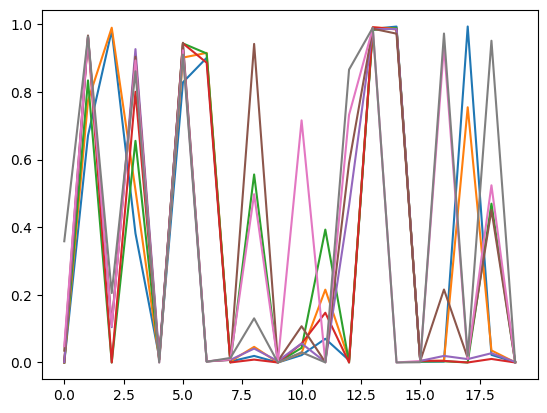

In [18]:
cluster_centers = kmeans_sax_ts.cluster_centers_
plt.plot(cluster_centers.reshape(cluster_centers.shape[1], -1))

plt.show()

Plot of distribution of sax time series with respect clusters.

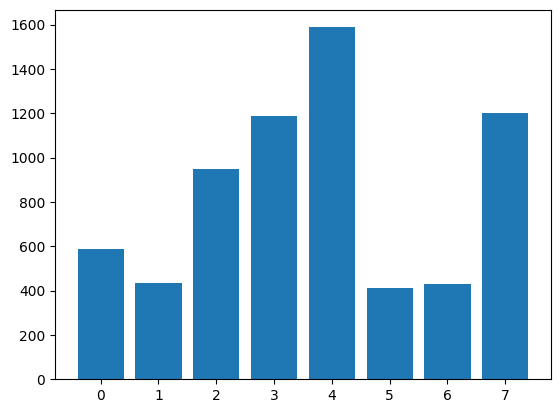

In [19]:
plot_clusters_distribution(kmeans_sax_ts)

Plot of distribution of sax time series according bot labels and clusters.

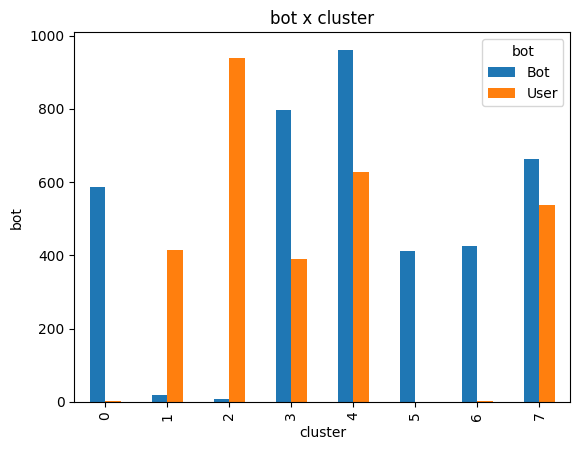

bot    Bot  User
row_0           
0      586     1
1       20   414
2        9   938
3      797   391
4      961   627
5      413     0
6      426     3
7      663   538


In [20]:
plot_bot_distribution(kmeans_sax_ts)

### Feature-based clustering

Function for features calculation by time series.

In [21]:
def calculate_features(data):
    return pd.DataFrame.from_records([{
        "mean": np.mean(values),
        "std": np.std(values),
        "variance": np.var(values),
        "median": np.median(values),
        "p10": np.percentile(values, 10),
        "p25": np.percentile(values, 25),
        "p75": np.percentile(values, 75),
        "p90": np.percentile(values, 90),
        "iqr": np.percentile(values, 75) - np.percentile(values, 25),
        "cv": np.std(values) / np.mean(values), # coefficient of variation
        "skew": stats.skew(values),
        "kurtosis": stats.kurtosis(values)
    } for values in data]).astype(float)

Features calculation with respect `X` and scaling of it.

In [22]:
features_df = calculate_features(X)

features = MinMaxScaler().fit_transform(features_df)

#### KMeans

Grid search of kmeans model on time series features.

  0%|          | 0/29 [00:00<?, ?it/s]

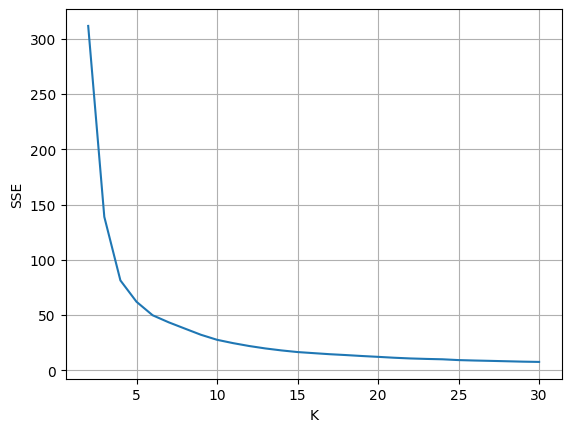

In [23]:
params_kmeans = [{'k': i, 'xvalue': i} for i in list(range(2, 31))]
def create_kmeans(param):
    return KMeans(n_clusters=param["k"], max_iter=100, n_init=10)

gridsearch_plot(create_kmeans, params_kmeans, features, ("K", "SSE"))

Kmeans model creation with best k found and fitting.

In [24]:
kmeans = create_kmeans({"k": 6})
kmeans.fit(features)

lg.info(f'SSE: {kmeans.inertia_}')
lg.info(f'Silhouette score: {silhouette_score(features, kmeans.labels_)}')
lg.info(f'CDM: {cdm_metric(features, kmeans.labels_)}')

2023-01-07 11:55:16,776 - root - INFO - SSE: 49.811865005940675
2023-01-07 11:55:17,170 - root - INFO - Silhouette score: 0.5507029752341045
2023-01-07 11:55:17,285 - root - INFO - CDM: 1.001124243894252


Plot of features colored by related cluster and centers.

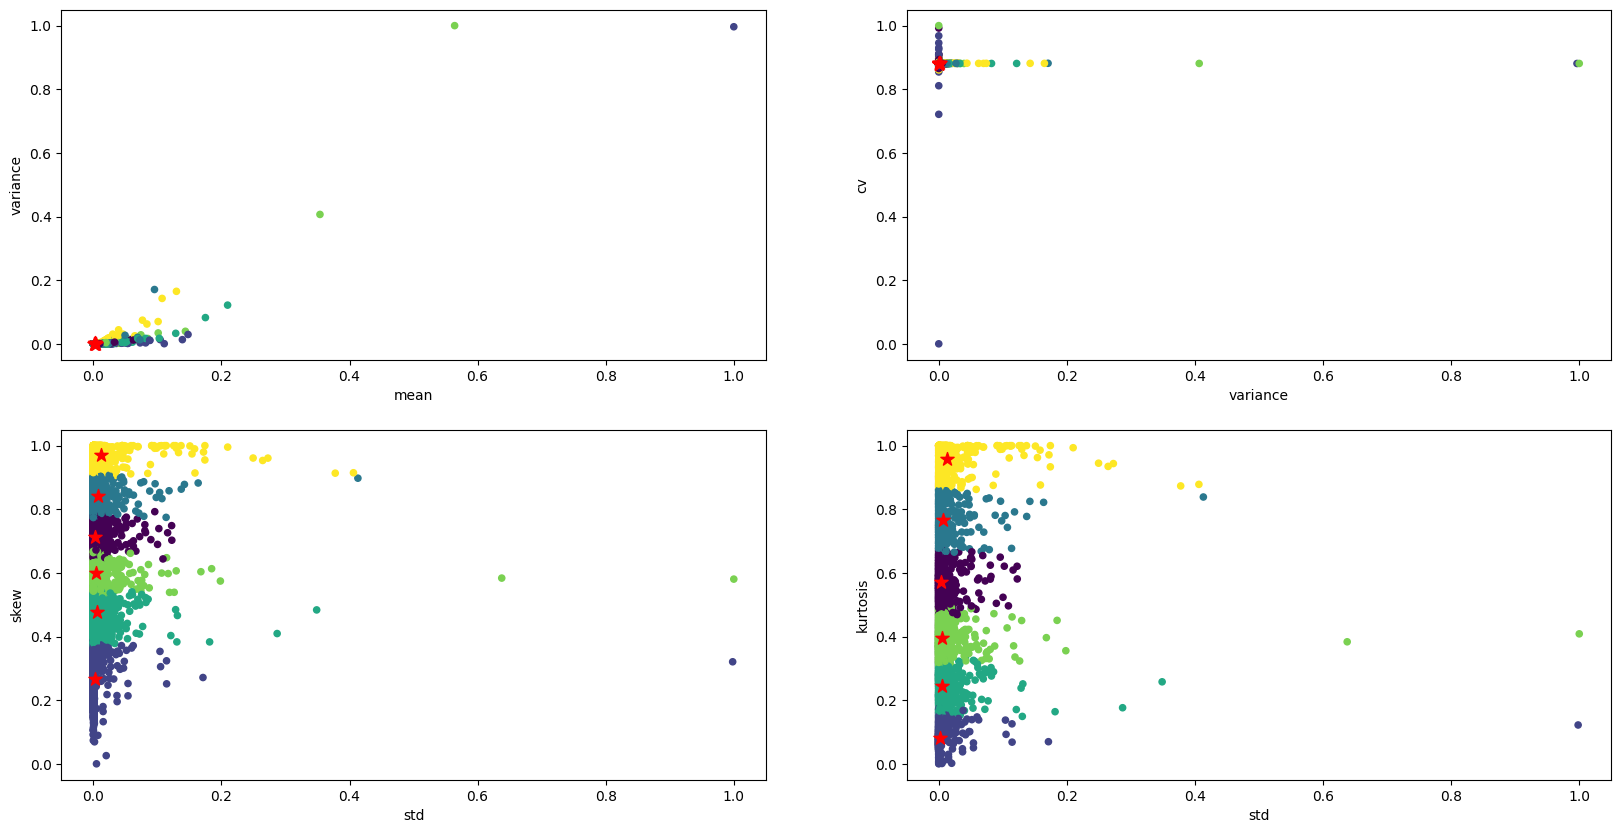

In [25]:
scatter_plt_pairs = [
    (0, 2),
    (2, 9),
    (1, 10),
    (1, 11)
]

configs = [
    {
        'type': 'scatter',
        'df': pd.DataFrame(features, columns=features_df.columns),
        'labels': kmeans.labels_,
        'centers': kmeans.cluster_centers_,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

Plot of features distribution among clusters.

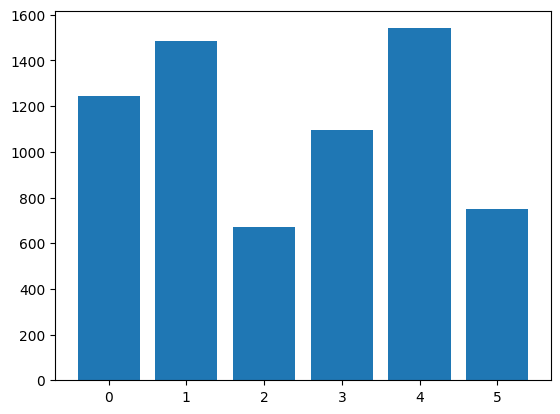

In [26]:
plot_clusters_distribution(kmeans)

Plot of features distribution according clusters and bot label.

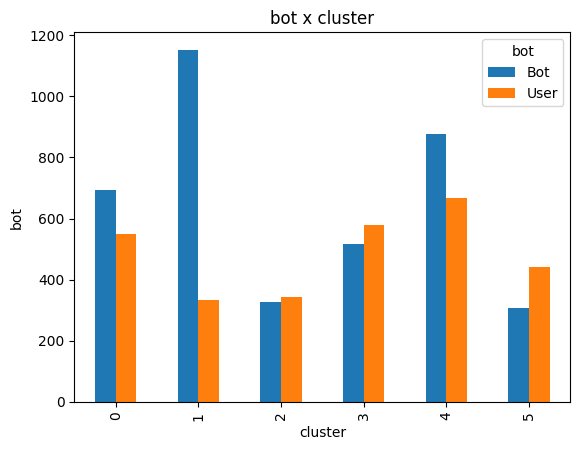

bot     Bot  User
row_0            
0       694   550
1      1152   332
2       328   343
3       518   579
4       875   666
5       308   442


In [27]:
plot_bot_distribution(kmeans)

#### DBSCAN

DBSCAN grid search on features dataset to find best `min_samples`.

  0%|          | 0/8 [00:00<?, ?it/s]

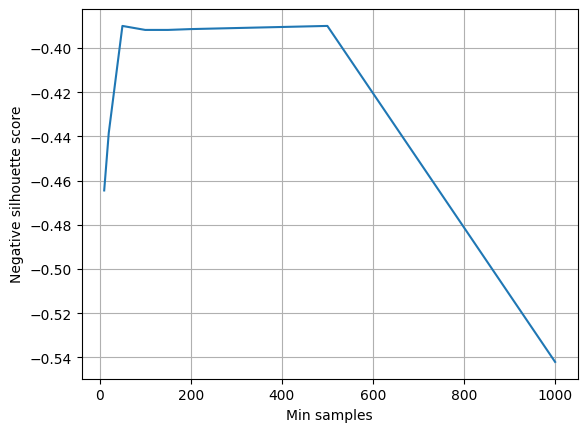

In [28]:
params_dbscan = [{'min_samples': i, 'xvalue': i} for i in [10, 20, 50, 100, 150, 200, 500, 1000]]
def create_dbscan(param):
    return DBSCAN(eps=0.1, min_samples=param["min_samples"])

def metric_callback(model):
    # check if there are at least 2 different values
    if len(set(model.labels_)) >= 2:
        # negative metric
        return - silhouette_score(features, model.labels_)

gridsearch_plot(create_dbscan, params_dbscan, features, ("Min samples", "Negative silhouette score"), metric_callback=metric_callback)

Plot of knee method used to find the best eps according best k found previously.

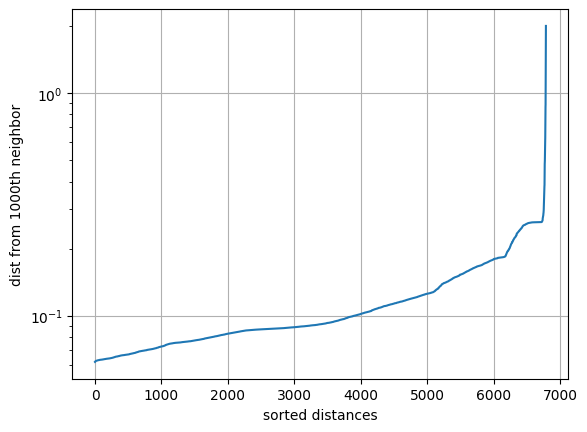

In [29]:
def plot_knee_method(df, k):
    dist = squareform(pdist(df, 'euclidean'))
    kth_distances = [d[np.argsort(d)[k]] for d in dist]
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel(f'dist from {k}th neighbor')
    plt.xlabel('sorted distances')
    plt.grid(True)
    plt.yscale("log")
    plt.show()

min_samples = 1000
plot_knee_method(features, min_samples)

DBSCAN model creation with best params and fitting.

In [30]:
dbscan = DBSCAN(eps=0.1, min_samples=min_samples)
dbscan.fit(features)

lg.info(f'Silhouette score: {silhouette_score(features, dbscan.labels_)}')
lg.info(f'CDM: {cdm_metric(features, dbscan.labels_)}')

2023-01-07 11:55:27,510 - root - INFO - Silhouette score: 0.5420689702136126
2023-01-07 11:55:27,623 - root - INFO - CDM: 1.0012749279538904


Plot of features colored by clusters.

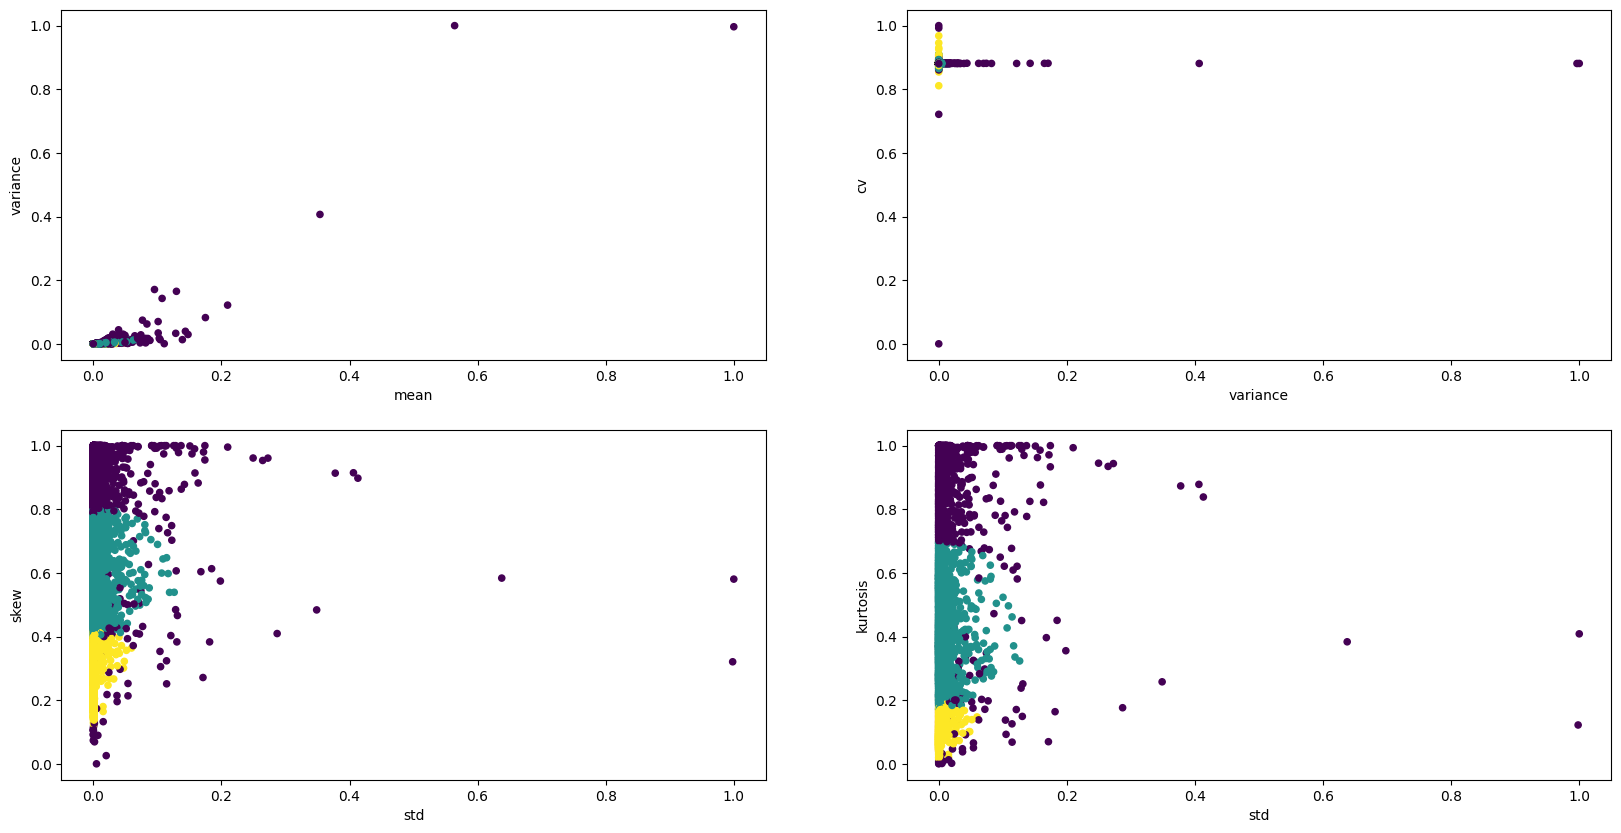

In [31]:
configs = [
    {
        'type': 'scatter',
        'df': pd.DataFrame(features, columns=features_df.columns),
        'labels': dbscan.labels_,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

Plot of features distribution among clusters.

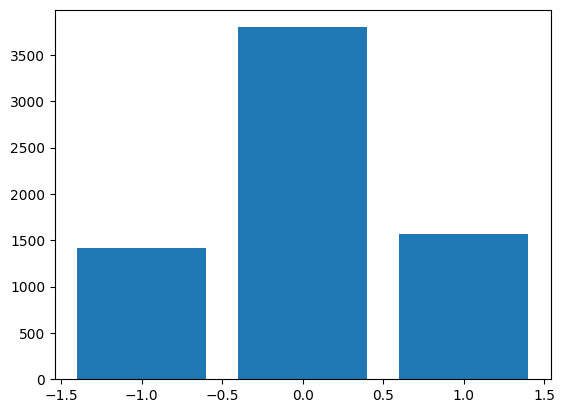

In [32]:
plot_clusters_distribution(dbscan)

Plot of features distribution according clusters and bot label.

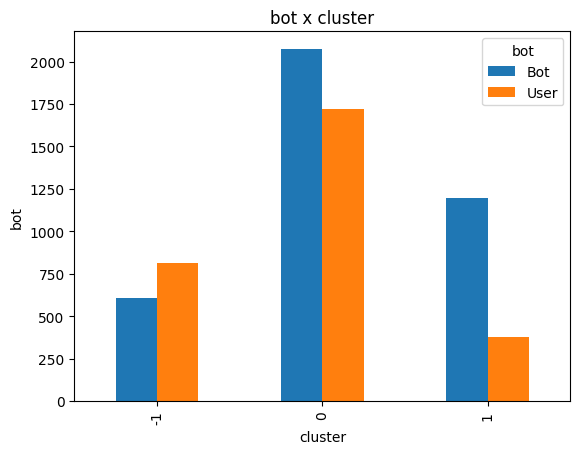

bot     Bot  User
row_0            
-1      607   813
 0     2074  1723
 1     1194   376


In [33]:
plot_bot_distribution(dbscan)

## Shapelets discovery

Dataset splitting to create train and test set and related set and labels.

In [4]:
dataset = users.copy()
label = dataset.pop("bot")

train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify=label, test_size=0.20)
train_set, test_set = [extract_success_score(t) for t in [train_set, test_set]]

Scaling of input sets.

In [5]:
scaler = TimeSeriesScalerMeanVariance()
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

Heuristic function used to find best shapelets quantity and dimensions.

In [6]:
n_classes = len(users["bot"].value_counts())

shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=train_set_scaled.shape[0],
    ts_sz=train_set_scaled.shape[1],
    n_classes=n_classes,
    l=0.01,                                     # fraction of time series to use in base shapelet
    r=5                                         # number of different shapelets
)

shapelet_sizes

{3: 6, 6: 6, 9: 6, 12: 6, 15: 6}

Function to create shapelet model.

In [7]:
def create_shapelet_model(params={}, max_iter=100, verbose=True):
    return ShapeletModel(
        n_shapelets_per_size=shapelet_sizes,
        max_iter=max_iter,
        batch_size=512,
        verbose=verbose,
        **params,
    )

Grid search on shapelet model.

In [8]:
params = dict(
    optimizer=["sgd", "adam"],
    weight_regularizer=[0.001, 0.0001],
)

grid_search = GridSearchCV(estimator=create_shapelet_model(verbose=False), param_grid=params, cv=4, n_jobs=-1, verbose=True)
grid_search.fit(train_set_scaled, train_label)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


2023-01-07 12:52:05.193952: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:05.798575: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:06.071641: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:06.239007: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:07.167326: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:10.411629: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:23.669876: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:52:26.905746: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-07 12:57:04.034515: W tensorflow

GridSearchCV(cv=4,
             estimator=LearningShapelets(batch_size=512, max_iter=100,
                                         n_shapelets_per_size={3: 6, 6: 6, 9: 6,
                                                               12: 6, 15: 6},
                                         verbose=False),
             n_jobs=-1,
             param_grid={'optimizer': ['sgd', 'adam'],
                         'weight_regularizer': [0.001, 0.0001]},
             verbose=True)

Print of best params and best scores.

In [9]:
grid_search.best_params_, grid_search.best_score_

({'optimizer': 'adam', 'weight_regularizer': 0.001}, 0.6349229110389265)

Shapelet model creation using best parameters selected and fitting.

In [10]:
shapelet_model = create_shapelet_model(grid_search.best_params_, max_iter=500)

shapelet_model.fit(train_set_scaled, train_label)

Epoch 1/500
11/11 [==============================] - 1s 25ms/step - loss: 1.5125 - binary_accuracy: 0.5541 - binary_crossentropy: 1.5106
Epoch 2/500
11/11 [==============================] - 0s 28ms/step - loss: 1.3301 - binary_accuracy: 0.5611 - binary_crossentropy: 1.3283
Epoch 3/500
11/11 [==============================] - 0s 24ms/step - loss: 1.1786 - binary_accuracy: 0.5612 - binary_crossentropy: 1.1768
Epoch 4/500
11/11 [==============================] - 0s 25ms/step - loss: 1.0588 - binary_accuracy: 0.5609 - binary_crossentropy: 1.0570
Epoch 5/500
11/11 [==============================] - 0s 24ms/step - loss: 0.9789 - binary_accuracy: 0.5633 - binary_crossentropy: 0.9772
Epoch 6/500
11/11 [==============================] - 0s 25ms/step - loss: 0.9268 - binary_accuracy: 0.5670 - binary_crossentropy: 0.9250
Epoch 7/500
11/11 [==============================] - 0s 26ms/step - loss: 0.8871 - binary_accuracy: 0.5743 - binary_crossentropy: 0.8853
Epoch 8/500
11/11 [======================

LearningShapelets(batch_size=512, max_iter=500,
                  n_shapelets_per_size={3: 6, 6: 6, 9: 6, 12: 6, 15: 6},
                  optimizer='adam', verbose=True, weight_regularizer=0.001)

Shapelet model prediction.

In [11]:
predicted_labels = shapelet_model.predict(test_set_scaled)
lg.info(f"Accuracy: {accuracy_score(test_label, predicted_labels)}")

3/3 [==============================] - 0s 19ms/step
2023-01-07 13:00:02,287 - root - INFO - Accuracy: 0.7083946980854198


### Shapelets plots and analysis

Plot of all found shapelets.

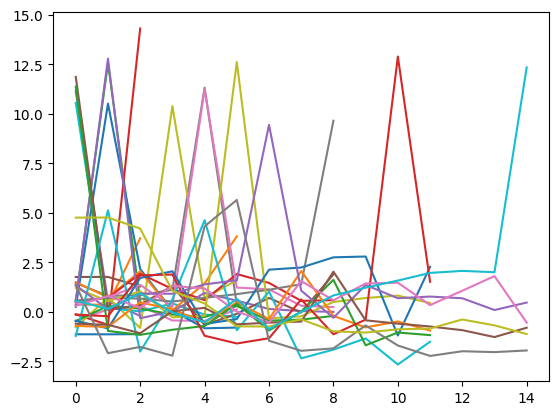

In [12]:
for shapelet in shapelet_model.shapelets_:
    plt.plot(shapelet)

plt.show()

Plot of some time series and related shapelets.

3/3 [==============================] - 0s 15ms/step


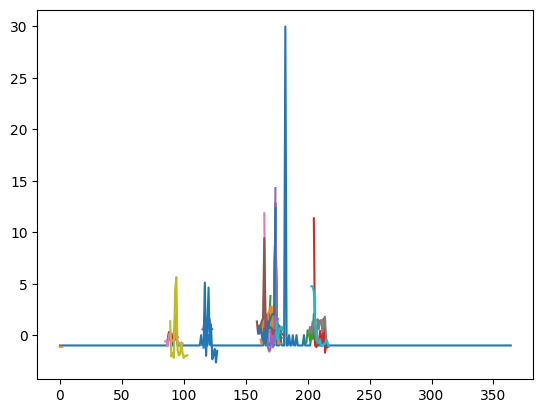

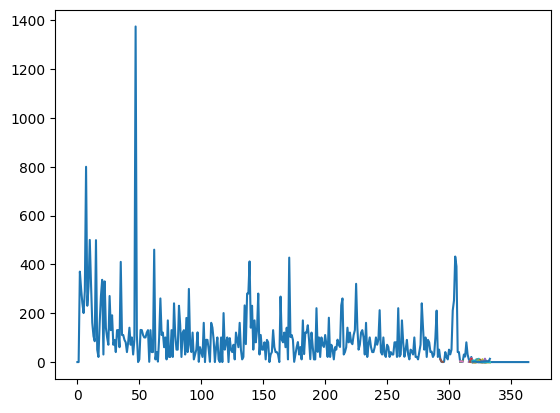

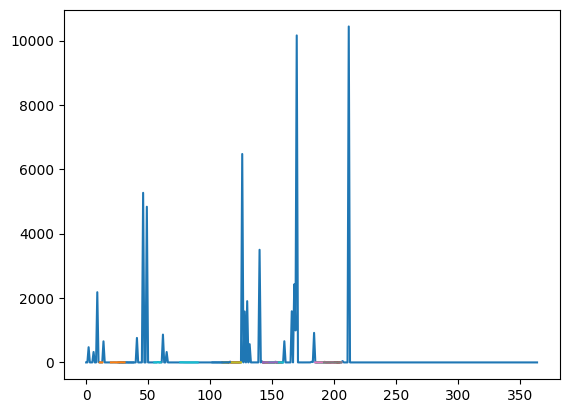

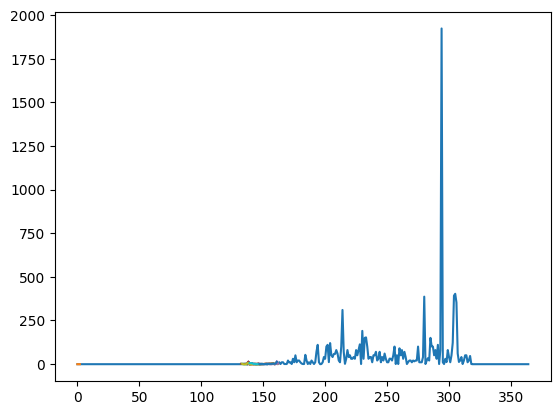

In [13]:
predicted_locations = shapelet_model.locate(test_set)
n_shapelets = sum(shapelet_sizes.values())

for ts_id in range(4):
    plt.plot(test_set[ts_id])
    for i, shapelet in enumerate(shapelet_model.shapelets_):
        t0 = predicted_locations[ts_id, i]
        xvalues = [(t0 + j) for j in range(len(shapelet))]
        plt.plot(xvalues, shapelet)
    plt.show()